In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [354]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=200, n_features=2, center_box=(0, 10.0), centers=2, cluster_std=0.5, random_state=1)
blobs = blobs.round(3)

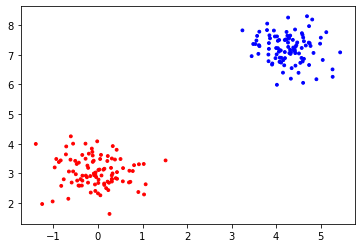

In [355]:
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap="bwr", s=8)

In [356]:
k = 2
D = 0.000000985
eps = 0.1
X = blobs
alpha = 5 #take alpha as an arbitrary number - constant, lets say 5
n_initial = len(X) # n is the size of the current point set, a.k.a. n is all of the initial points
Opt = -int(- (alpha+1) * (np.log(np.sqrt(2)) / np.log(1 + eps)) // 1) #rounded up, number of guesses
print(Opt)

22


In [357]:
def visualize_splitting(Z, c_centers, lines, X, initial_bbox, title="Sub-Cell Construction"):
    plt.figure(figsize=(8, 6))

    # Plot the initial bounding box
    bbox = np.array(initial_bbox)
    plt.plot(bbox[:, 0], bbox[:, 1], color='green', linestyle='-', linewidth=1, label='Initial Bounding Box')

    # Plot the original points
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='.', label='Original Points')

    # Plot points in light cells
    #for points_in_cell in Z:
    #    cell_points = np.array(points_in_cell)
    #    plt.scatter(cell_points[:, 0], cell_points[:, 1], color='orange', marker='.', label='Light Cell')

    # Plot cell centers
    centers = np.array(c_centers)
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', label='Cell Centers')

    # Plot the splitting lines
    for line in lines:
        for rect_coords in line:
            rect = patches.Rectangle(
                (rect_coords[0][0], rect_coords[1][0]),  # Bottom-left and top-right corner
                rect_coords[0][1] - rect_coords[0][0],   # Width
                rect_coords[1][1] - rect_coords[1][0],   # Height
                edgecolor='green',
                facecolor='none'
            )
            plt.gca().add_patch(rect)

    plt.title(title)
    plt.axis("off")
    #plt.xlabel('X-axis')
    #plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(False)
    plt.show()

In [358]:
def recursive_split(X, cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines=[], Z=[], c_centers=[]):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
    threshold = delta*opt / pow(2, 1/(i+1))  # temp pow(2, i)  pow(2, 1/(i+1))
    print("Threshold value:", round(threshold, 5), "Points in cell:", len(points_in_cell))
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**1 if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            print("\033[1m Points in light cell:\n", points_in_cell, "\033[0;0m")
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
    else: 
        print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if nr_of_cells <= cs and (i+1 < np.log(delta * opt) + 1):    
            # Step #3.1 if c is heavy then
            # Split the cell
            # First time this executes - only if g**1 is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i, with side length 2**i with each recursion
            i = i + 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            lines.append([
                ((x1, mid_x), (y1, mid_y)),  # Top-left
                ((mid_x, x2), (y1, mid_y)),  # Top-right
                ((x1, mid_x), (mid_y, y2)),  # Bottom-left
                ((mid_x, x2), (mid_y, y2))])  # Bottom-right
            
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, sub_cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines,
                                Z, c_centers)
    return Z, c_centers, lines

In [359]:
def coreset(Z, rep_c, delta, cs, eps):
    
    # rep_c = c_centers
    # Step #4.2: number of  points in each cell
    n_c = [len(c) for c in Z]
    
    # Step #4.3: pair respective center coordinates with number of points in each cell
    S = [] #pairs
    for index in range(0, len(rep_c)):
        S.append([rep_c[index], n_c[index]])
    #print(rep_c, n_c)
    if len(S) > cs*(1+eps):
        return None # failure indication
    else:
        return S

In [360]:
def coreset_construction(X, k, D, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #0: empty arr to store light cells c
        Z = []
        # Arr to store the lines defining sub-cells
        lines = []
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        delta = ( 1 / ( (4*k*np.sqrt(D)) * (np.log(n_initial)+1) ) ) * pow( ( eps / (14*np.sqrt(D)) ), D)
        print("delta =", round(delta, 5))
        # Calculate coreset size
        cs = 2/delta + (np.log(n_initial) + 2) * k * pow(2, D)
        print("cs =", round(cs, 5))

        for j in range(0, Opt):
        #for j in range(Opt, -1, -1):
            print("\nIteration j = " + str(j) + ", with approximation Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            
            # i-th iteration tracking for recursive alg
            i=0
            
            # Start the recursive splitting
            # Here Opt = (1+eps)^j
            Z, c_centers, lines = recursive_split(X, Y, k, D, eps, pow((1+eps), j), n_initial,
                                                  delta, nr_of_cells, cs, i, lines, Z)

            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps)
                        
            if S is not None:
                print("\n Coreset constructed: \n", S)
                
                initial_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]
                visualize_splitting(Z, c_centers, lines, X, initial_bbox)
                #print(lines)
                
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

The array is non-empty, proceeding with coreset construction algorithm
delta = 19.99715
cs = 14.69666

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 9.99858 Points in cell: 198
Current number of cells: 1
Threshold value: 14.14012 Points in cell: 100
Current number of cells: 4
Threshold value: 15.87175 Points in cell: 51
Current number of cells: 7
Threshold value: 16.81554 Points in cell: 3
 Points in light cell:
 [[-0.665  2.143]
 [-1.252  1.966]
 [-1.017  2.052]] 
Threshold value: 16.81554 Points in cell: 6
 Points in light cell:
 [[-0.162  2.352]
 [ 0.232  2.435]
 [ 0.     2.325]
 [-0.059  2.407]
 [ 0.259  1.632]
 [ 0.054  2.26 ]] 
Threshold value: 16.81554 Points in cell: 6
 Points in light cell:
 [[-0.59   2.69 ]
 [-0.824  2.578]
 [-0.652  3.062]
 [-0.971  3.2  ]
 [-0.557  3.064]
 [-0.768  2.799]] 
Threshold value: 16.81554 Points in cell: 36
Current number of cells: 10
Threshold value: 15.87175 Points in cell: 15
 Points in light cell:
 [[0.906 2.37 ]

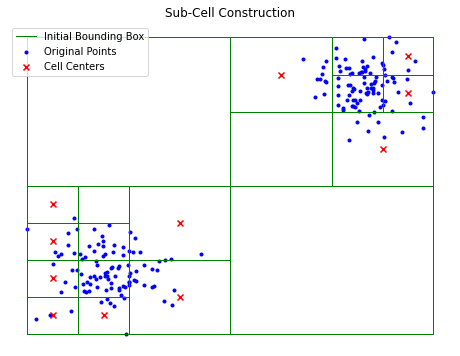

[[(-0.9681875, 2.0485625), 3],
 [(-0.11456250000000007, 2.0485625), 6],
 [(-0.9681875, 2.8816875), 6],
 [(1.1658749999999998, 2.465125), 15],
 [(-0.9681875, 3.7148125), 8],
 [(-0.9681875, 4.5479375), 1],
 [(1.1658749999999998, 4.131375), 7],
 [(4.580375, 5.797625), 9],
 [(2.873125, 7.463875000000001), 10],
 [(5.007187500000001, 7.0473125), 11],
 [(5.007187500000001, 7.880437500000001), 6]]

In [361]:
coreset_construction(X, k, D, eps, n_initial)

In [345]:
20*(1/pow(2, 1/5))

17.411011265922482

In [68]:
#((x1, mid_x), (y1, mid_y)),  # Top-left
#((mid_x, x2), (y1, mid_y)),  # Top-right
#((x1, mid_x), (mid_y, y2)),  # Bottom-left
#((mid_x, x2), (mid_y, y2))]) # Bottom-right

In [ ]:
# 2nd visualization with only coreset centers
#opt, adjust stopping condition
#2 moon
#2circle